In [1]:
using Base.Threads
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsBase
using StatsFuns
using StatsPlots
default(fmt=:png, titlefontsize=10, guidefontsize=8, tickfontsize=6)

In [2]:
function prob_x_le_y(distx, disty, a=0.0)
    H(y) = cdf(distx, y) * pdf(disty, y-a)
    quadgk(H, extrema(disty + a)...)[1]
end

function tieshift(distx, disty; probtie=0.5)
    #s = max(std(distx), std(disty))
    #m = median(distx) - median(disty)
    #find_zero(a -> prob_x_le_y(distx, disty, a) - probtie,
    #    (amin, amax), Bisection())
    find_zero(a -> prob_x_le_y(distx, disty, a) - probtie, 0.0)
end

@show tieshift(Normal(0, 1), Normal(2, 2))
@show tieshift(Normal(0, 1), Laplace(2, 2))
@show tieshift(Normal(0, 1), Uniform(0, 1));

tieshift(Normal(0, 1), Normal(2, 2)) = -1.9999999999999232
tieshift(Normal(0, 1), Laplace(2, 2)) = -1.9999999999994498
tieshift(Normal(0, 1), Uniform(0, 1)) = -0.49999999999999983


In [3]:
distx, disty = Gamma(6, 1), Gamma(2, 3)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (5.670161188712071, 5.035040970049984)
median(distx) - median(disty) = 0.6351202186620872
tieshift(distx, disty) = 0.6001914280974744


In [4]:
distx, disty = Uniform(), Chisq(1)
@show median(distx), median(disty)
@show median(distx) - median(disty)
@show tieshift(distx, disty);

(median(distx), median(disty)) = (0.5, 0.4549364231195729)
median(distx) - median(disty) = 0.045063576880427114
tieshift(distx, disty) = -0.02680686952216707


In [5]:
function sim(TestFunc = MannWhitneyUTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6)
    pval = Vector{Float64}(undef, L)
    tmpX = [Vector{Float64}(undef, m) for _ in 1:nthreads()]
    tmpY = [Vector{Float64}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(distx, tmpX[threadid()])
        Y = rand!(disty, tmpY[threadid()])
        pval[i] = pvalue(TestFunc(X, Y))
    end
    pval
    ecdf(pval)
end

function printcompact(io, xs...)
    print(IOContext(io, :compact => true), xs...)
end

function distname(dist)
    replace(sprint(printcompact, dist), r"\{[^\}]*\}"=>"")
end

function plot_ecdf(ecdf_pval, TestFunc, distx, disty, m, n, a; kwargs...)
    plot(p -> ecdf_pval(p), 0, 0.1; label="ecdf of P-values")
    plot!([0, 0.1], [0, 0.1]; label="", ls=:dot, c=:black)
    plot!(legend=:topleft)
    plot!(xtick=0:0.01:0.1, ytick=0:0.01:1)
    plot!(xguide="nominal significance level α", 
        yguide="probability of P-value < α")
    s = (a < 0 ? "" : "+") * string(round(a; digits=4))
    title!("$TestFunc\n\
        X: $(distname(distx)), m=$m\n\
        Y: $(distname(disty))$s, n=$n")
    plot!(size=(400, 450))
    plot!(; kwargs...)
end

function plot_pvals(
        TestFunc1 = MannWhitneyUTest,
        TestFunc2 = UnequalVarianceTTest;
        distx = Normal(0, 1), disty = Normal(0, 4), m = 100, n = 50,
        L = 10^6, a = nothing, kwargs...)
    @show (mean(distx), std(distx))
    @show (mean(disty), std(disty))
    
    if isnothing(a)
        @show a = tieshift(distx, disty)
        @show prob_x_le_y(distx, disty + a)
    else
        @show a
        @show median(distx) - median(disty)
    end
    ecdf_pval1 = @time sim(TestFunc1;
        distx = distx,
        disty = disty + a,
        m, n, L, kwargs...)
    ymax1 = ecdf_pval1(0.1)
    @show Δμ = mean(distx) - mean(disty)
    @show mean(distx), mean(disty + Δμ)
    ecdf_pval2 = @time sim(TestFunc2;
        distx = distx,
        disty = disty + Δμ,
        m, n, L, kwargs...)
    ymax2 = ecdf_pval2(0.1)
    ymax = max(ymax1, ymax2)
    P1 = plot_ecdf(ecdf_pval1, TestFunc1, distx, disty, m, n, a;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    P2 = plot_ecdf(ecdf_pval2, TestFunc2, distx, disty, m, n, Δμ;
        ylim=(-0.002, 1.02*ymax), kwargs...)
    plot(P1, P2; size=(800, 450), topmargin=3.5Plots.mm)
end

plot_pvals (generic function with 3 methods)

## 正規分布

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.770351 seconds (8.00 M allocations: 2.011 GiB, 25.35% gc time, 23.54% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.806741 seconds (9.42 M allocations: 230.342 MiB, 15.66% gc time, 36.56% compilation time)


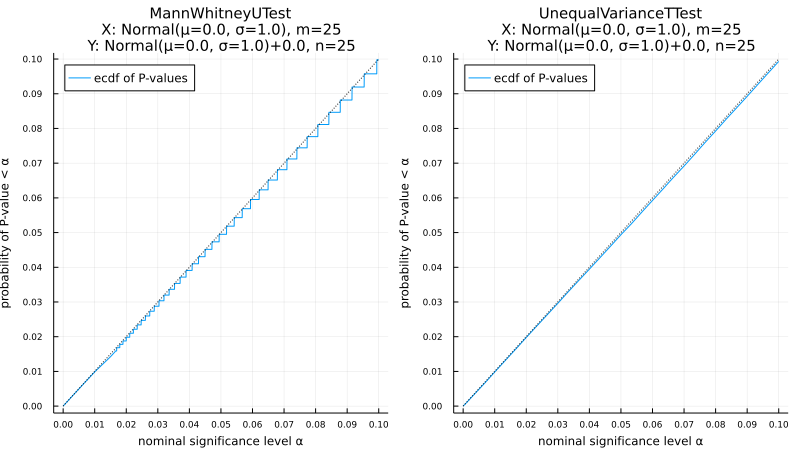

In [6]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 25, n = 25)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.517434 seconds (7.00 M allocations: 2.690 GiB, 39.63% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.414273 seconds (9.00 M allocations: 206.012 MiB, 18.94% gc time)


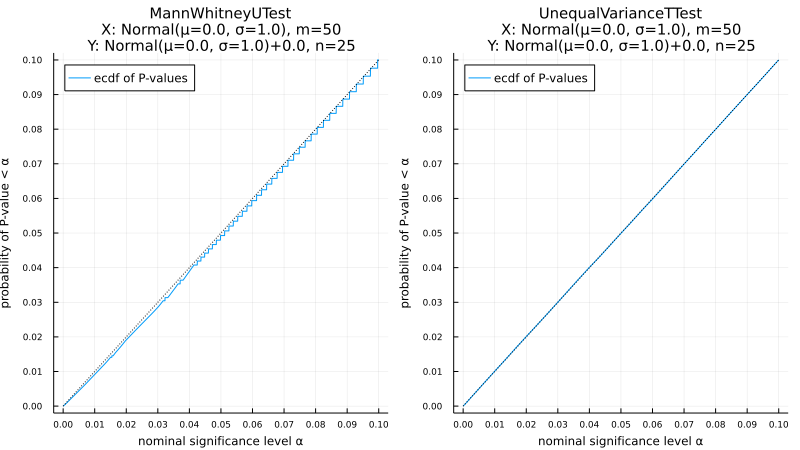

In [7]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 50, n = 25)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.412159 seconds (7.00 M allocations: 1.960 GiB, 35.56% gc time, 0.31% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.372885 seconds (9.00 M allocations: 206.009 MiB)


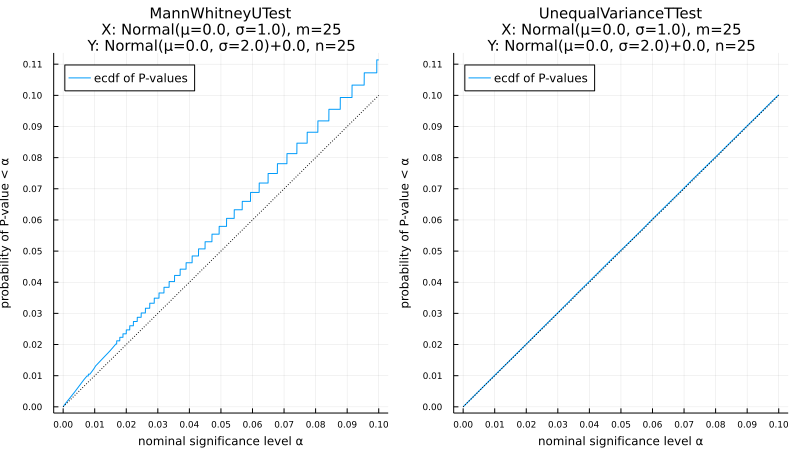

In [8]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 25, n = 25)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.660340 seconds (7.00 M allocations: 2.690 GiB, 43.89% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.370455 seconds (9.00 M allocations: 206.012 MiB)


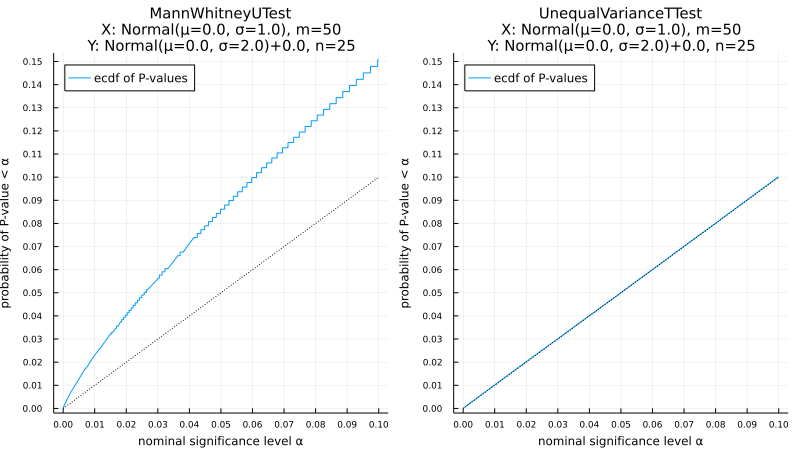

In [9]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 50, n = 25)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  1.439379 seconds (7.00 M allocations: 2.690 GiB, 38.11% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.434746 seconds (9.00 M allocations: 206.012 MiB, 23.54% gc time)


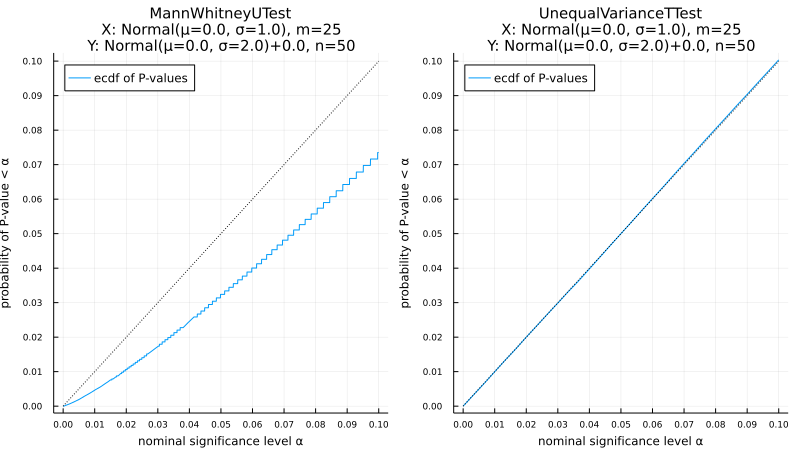

In [10]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 25, n = 50)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.618876 seconds (7.00 M allocations: 1014.730 MiB, 32.28% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.410491 seconds (9.00 M allocations: 206.007 MiB, 23.64% gc time)


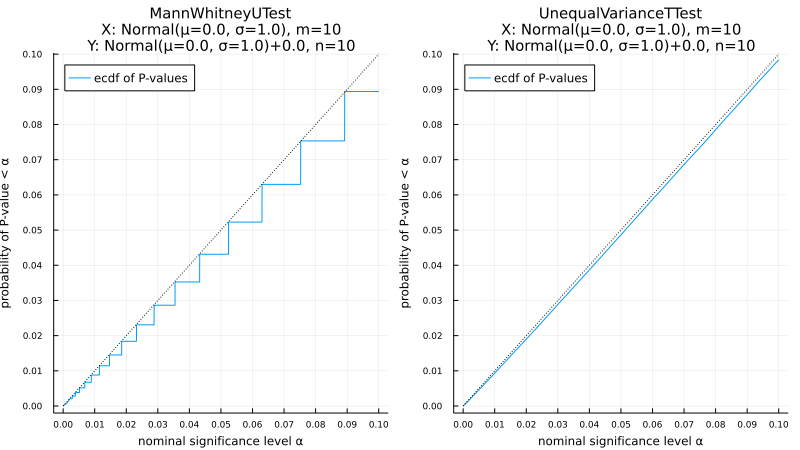

In [11]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 1.0)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.748605 seconds (7.00 M allocations: 1.289 GiB, 30.09% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.425715 seconds (9.00 M allocations: 206.008 MiB, 21.04% gc time)


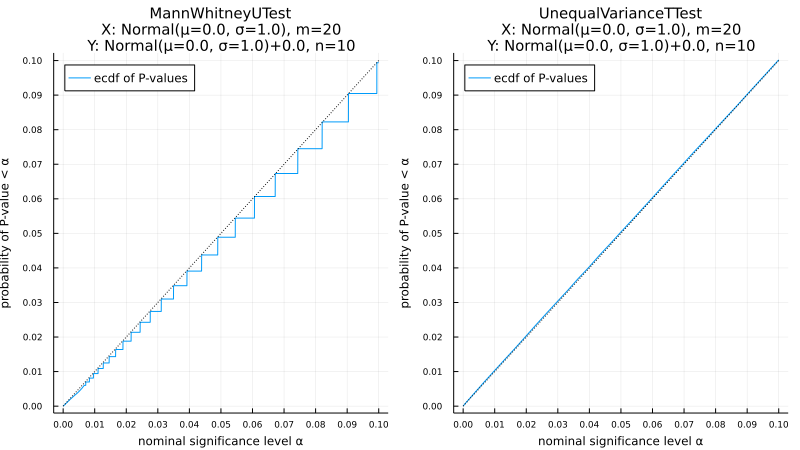

In [12]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 1), m = 20, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.652908 seconds (7.00 M allocations: 1014.730 MiB, 34.00% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.283691 seconds (9.00 M allocations: 206.007 MiB)


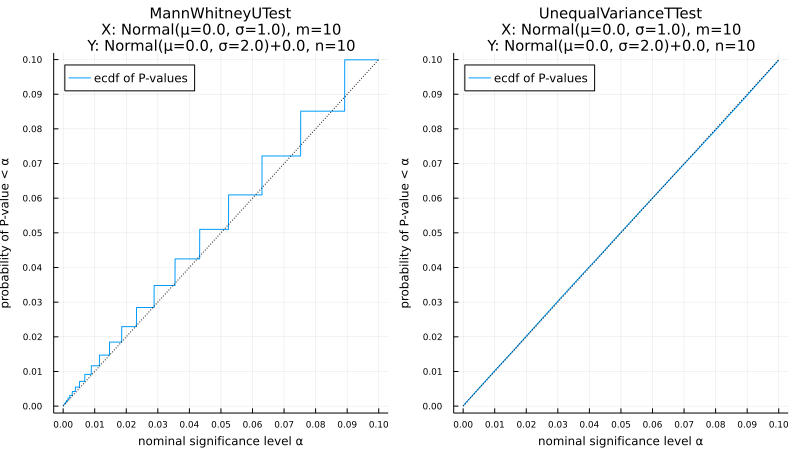

In [13]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.914217 seconds (7.00 M allocations: 1.289 GiB, 39.98% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.353540 seconds (9.00 M allocations: 206.007 MiB)


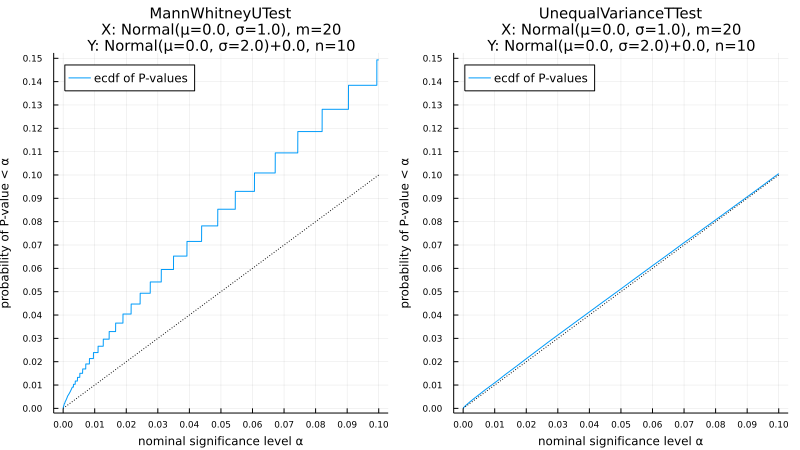

In [14]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 20, n = 10)

(mean(distx), std(distx)) = (0.0, 1.0)
(mean(disty), std(disty)) = (0.0, 2.0)
a = tieshift(distx, disty) = 7.685641860444171e-14
prob_x_le_y(distx, disty + a) = 0.5
  0.831309 seconds (7.00 M allocations: 1.289 GiB, 33.06% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.303816 seconds (9.00 M allocations: 206.008 MiB)


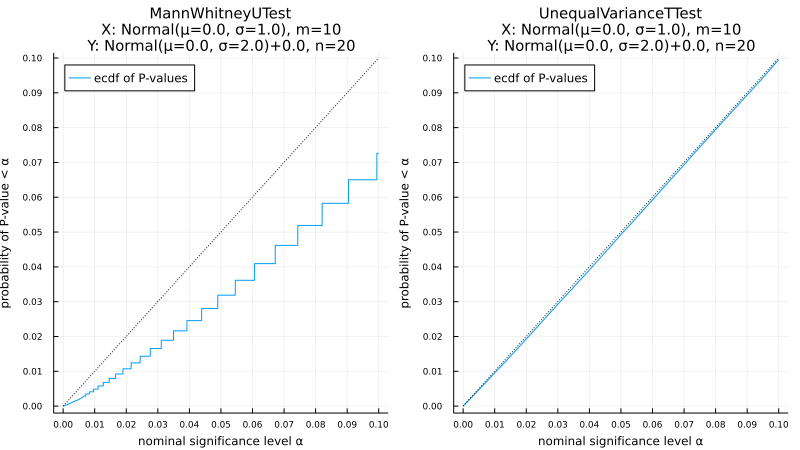

In [15]:
plot_pvals(distx = Normal(0, 1), disty = Normal(0, 2), m = 10, n = 20)

## ガンマ分布

(mean(distx), std(distx)) = (6.0, 4.242640687119285)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.614098 seconds (7.22 M allocations: 1.971 GiB, 19.57% gc time, 9.88% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.747163 seconds (9.07 M allocations: 210.896 MiB, 15.57% gc time, 10.64% compilation time)


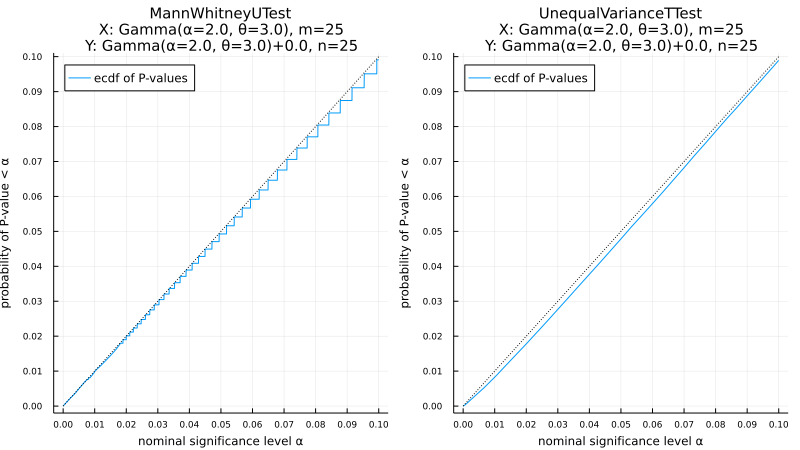

In [16]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 25, n = 25)

(mean(distx), std(distx)) = (6.0, 4.242640687119285)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  1.884774 seconds (7.00 M allocations: 2.690 GiB, 37.32% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.673401 seconds (9.00 M allocations: 206.012 MiB)


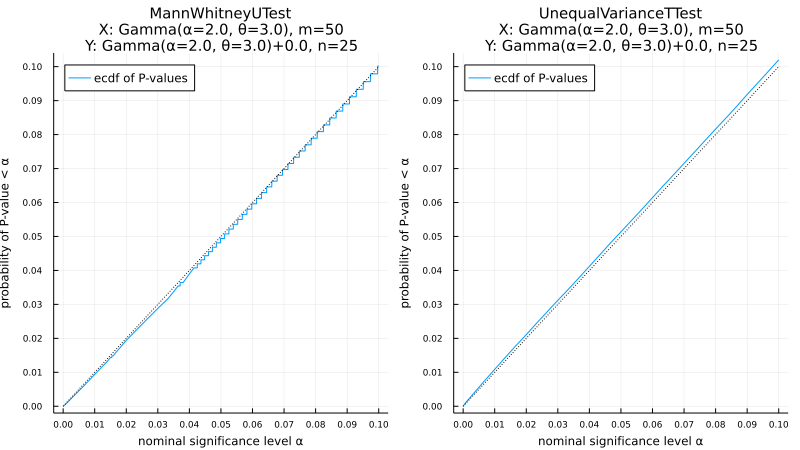

In [17]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 50, n = 25)

(mean(distx), std(distx)) = (6.0, 2.449489742783178)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.481314 seconds (7.00 M allocations: 1.960 GiB, 27.21% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.522111 seconds (9.00 M allocations: 206.009 MiB)


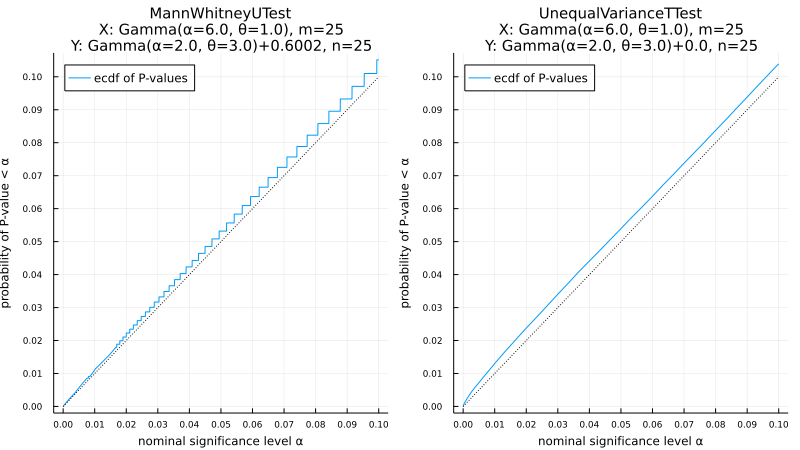

In [18]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 25, n = 25)

(mean(distx), std(distx)) = (6.0, 2.449489742783178)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.771821 seconds (7.00 M allocations: 2.690 GiB, 36.37% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.583682 seconds (9.00 M allocations: 206.012 MiB)


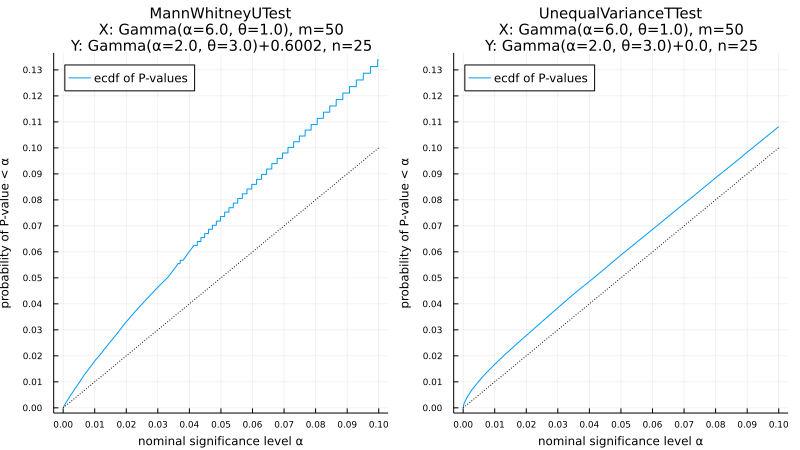

In [19]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 50, n = 25)

(mean(distx), std(distx)) = (6.0, 2.449489742783178)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.962562 seconds (7.00 M allocations: 2.690 GiB, 38.33% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.734128 seconds (9.00 M allocations: 206.012 MiB)


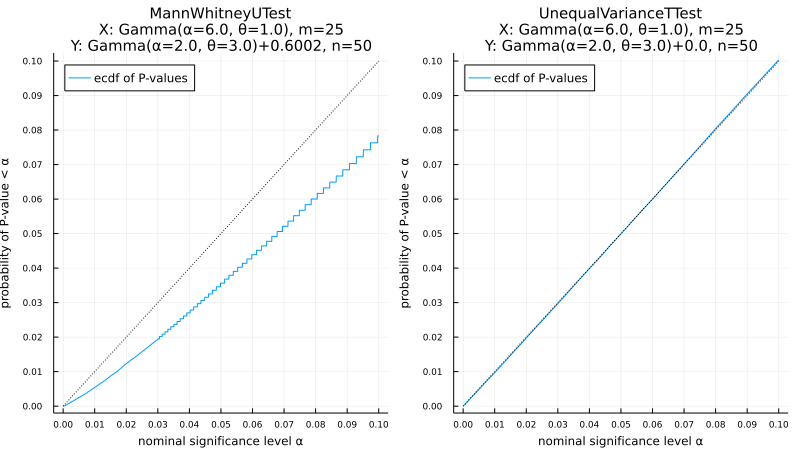

In [20]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 25, n = 50)

(mean(distx), std(distx)) = (6.0, 4.242640687119285)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.661508 seconds (7.00 M allocations: 1014.729 MiB, 23.42% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.494675 seconds (9.00 M allocations: 206.007 MiB, 21.55% gc time)


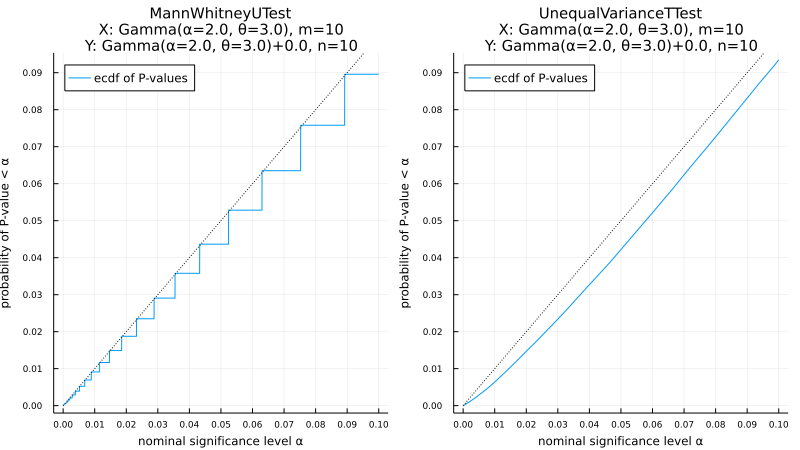

In [21]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 10, n = 10)

(mean(distx), std(distx)) = (6.0, 4.242640687119285)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.964222 seconds (7.00 M allocations: 1.289 GiB, 28.24% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.448469 seconds (9.00 M allocations: 206.008 MiB)


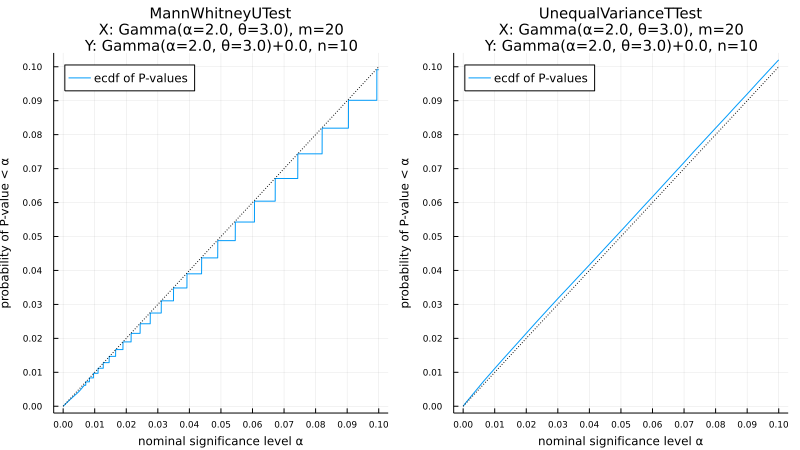

In [22]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 20, n = 10)

(mean(distx), std(distx)) = (6.0, 4.242640687119285)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.49999999999999983
  0.752925 seconds (7.00 M allocations: 1014.730 MiB, 31.67% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.536323 seconds (9.00 M allocations: 206.007 MiB, 24.64% gc time)


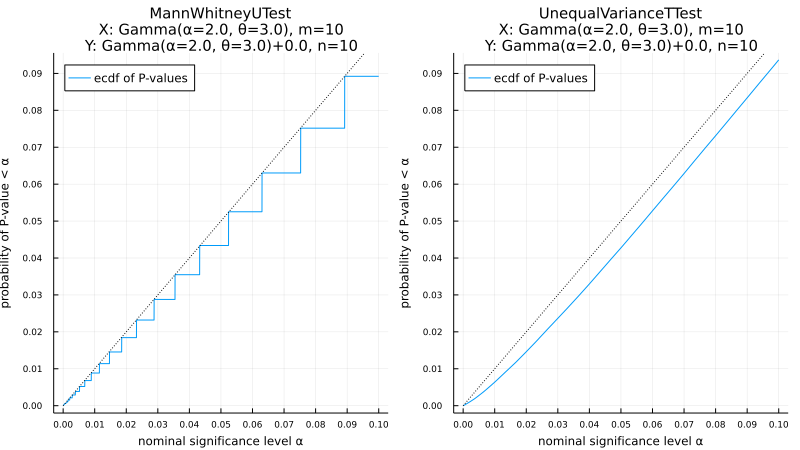

In [23]:
plot_pvals(distx = Gamma(2, 3), disty = Gamma(2, 3), m = 10, n = 10)

(mean(distx), std(distx)) = (6.0, 2.449489742783178)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.063914 seconds (7.00 M allocations: 1.289 GiB, 38.41% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.433691 seconds (9.00 M allocations: 206.008 MiB)


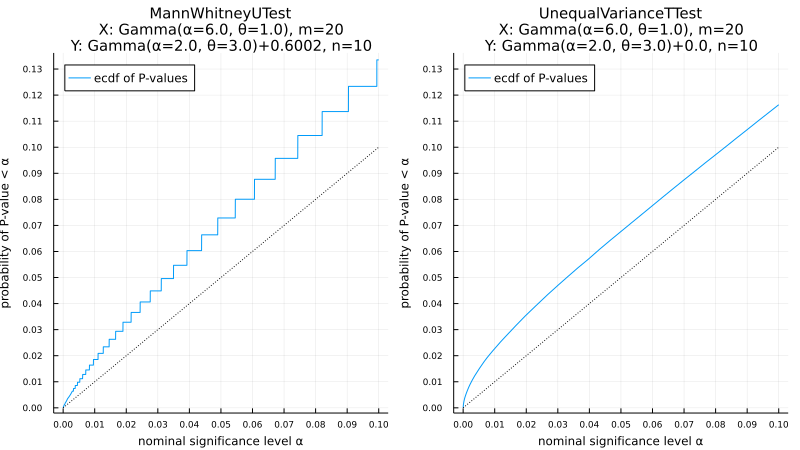

In [24]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 20, n = 10)

(mean(distx), std(distx)) = (6.0, 2.449489742783178)
(mean(disty), std(disty)) = (6.0, 4.242640687119285)
a = tieshift(distx, disty) = 0.6001914280974744
prob_x_le_y(distx, disty + a) = 0.5
  1.244048 seconds (7.00 M allocations: 1.289 GiB, 41.45% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (6.0, 6.0)
  0.440144 seconds (9.00 M allocations: 206.007 MiB)


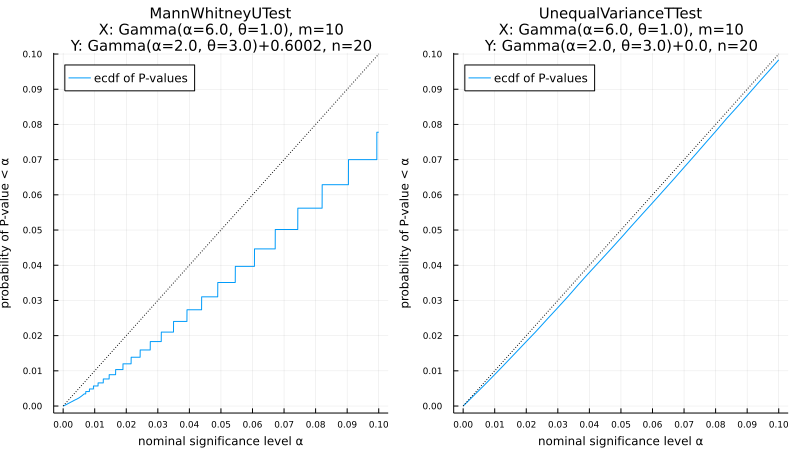

In [25]:
plot_pvals(distx = Gamma(6, 1), disty = Gamma(2, 3), m = 10, n = 20)

## 雑多

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.679849 seconds (7.06 M allocations: 1017.805 MiB, 29.08% gc time, 7.10% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.402987 seconds (9.07 M allocations: 210.952 MiB, 24.68% compilation time)


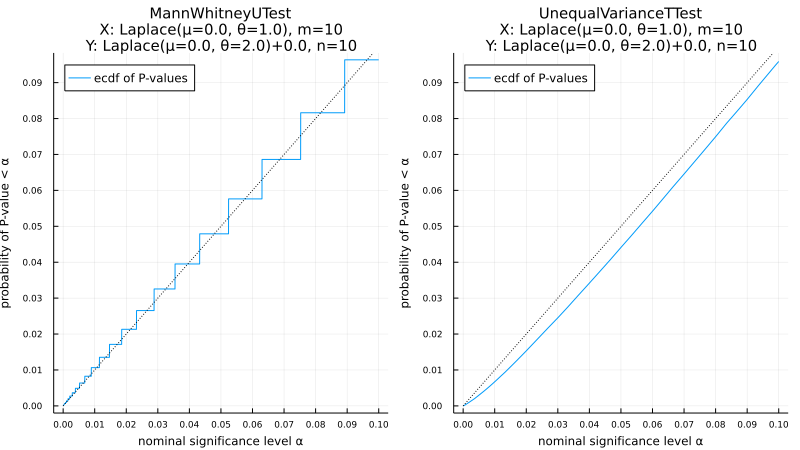

In [26]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.392636 seconds (7.00 M allocations: 1.960 GiB, 31.90% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.389181 seconds (9.00 M allocations: 206.009 MiB)


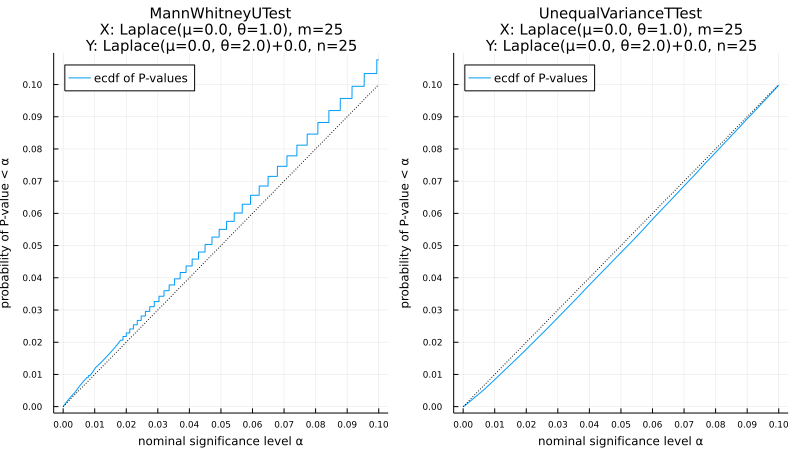

In [27]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 25, n = 25)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  2.134094 seconds (7.00 M allocations: 3.539 GiB, 41.07% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.755537 seconds (9.00 M allocations: 206.014 MiB, 27.52% gc time)


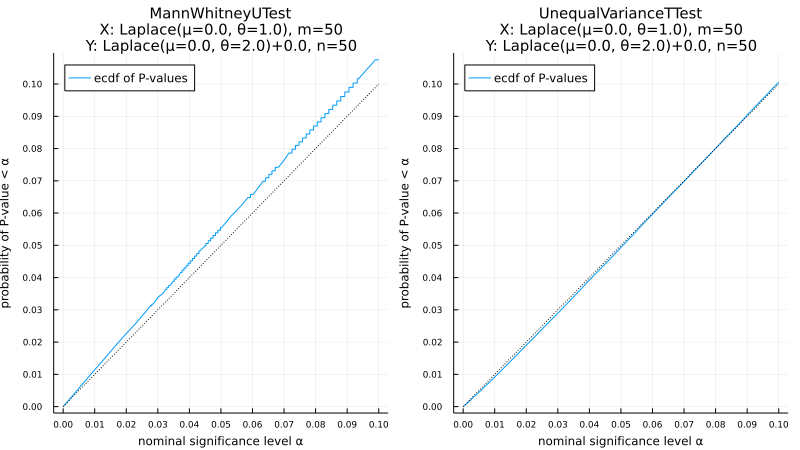

In [28]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 50)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.920372 seconds (7.00 M allocations: 1.289 GiB, 35.55% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.334441 seconds (9.00 M allocations: 206.008 MiB)


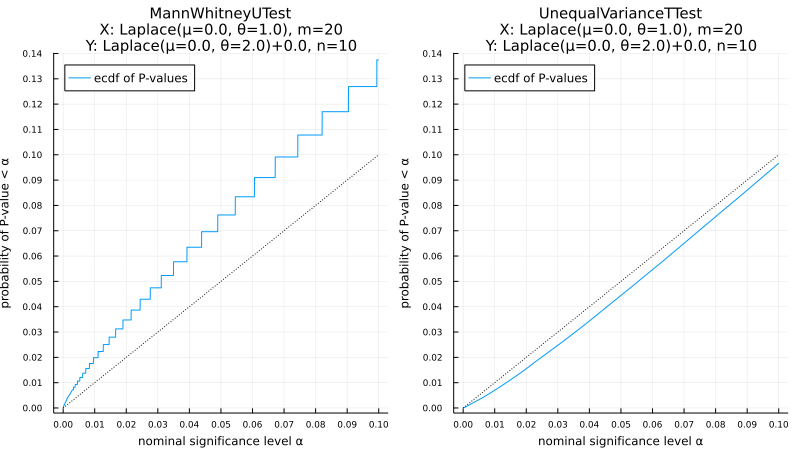

In [29]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 20, n = 10)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  0.869698 seconds (7.00 M allocations: 1.289 GiB, 27.08% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.490466 seconds (9.00 M allocations: 206.007 MiB, 31.15% gc time)


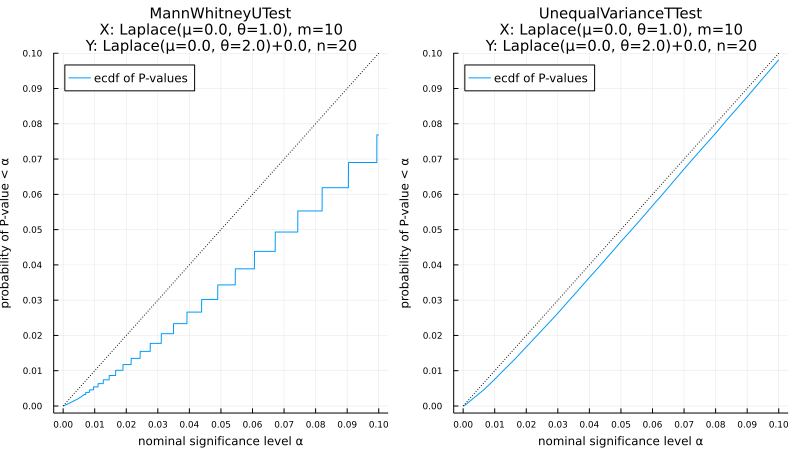

In [30]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 10, n = 20)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.775261 seconds (7.00 M allocations: 2.690 GiB, 39.62% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.438402 seconds (9.00 M allocations: 206.012 MiB)


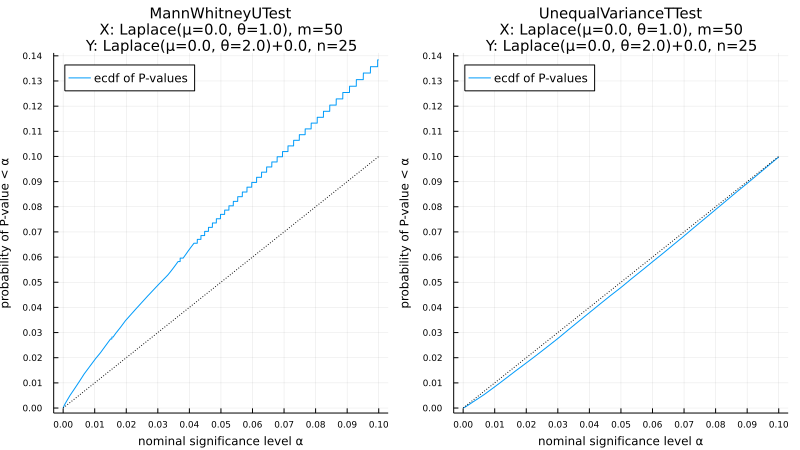

In [31]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 50, n = 25)

(mean(distx), std(distx)) = (0.0, 1.4142135623730951)
(mean(disty), std(disty)) = (0.0, 2.8284271247461903)
a = tieshift(distx, disty) = 2.9690350070884103e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.846148 seconds (7.00 M allocations: 2.690 GiB, 36.99% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.591600 seconds (9.00 M allocations: 206.012 MiB, 18.90% gc time)


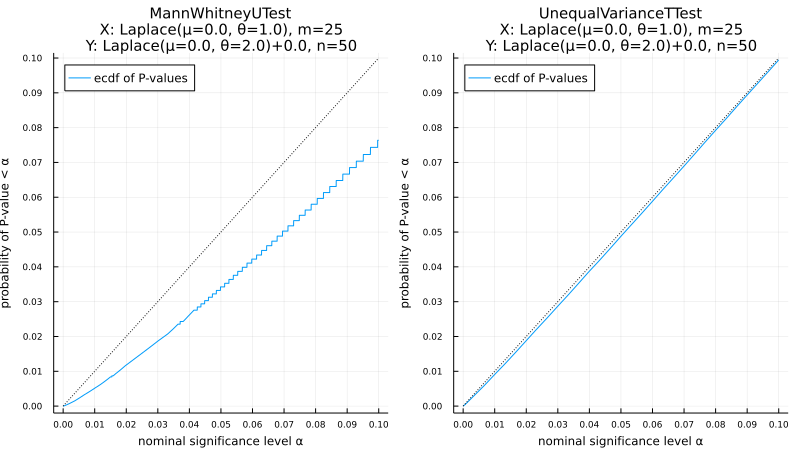

In [32]:
plot_pvals(distx = Laplace(0, 1), disty = Laplace(0, 2), m = 25, n = 50)

(mean(distx), std(distx)) = (0.0, 0.5773502691896257)
(mean(disty), std(disty)) = (0.0, 1.1547005383792515)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.796612 seconds (7.59 M allocations: 1.018 GiB, 22.10% gc time, 25.26% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.415059 seconds (9.07 M allocations: 210.805 MiB, 20.56% compilation time)


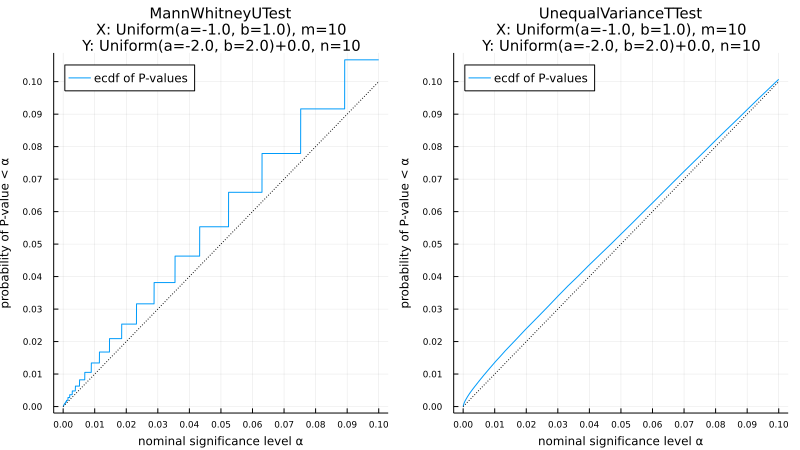

In [33]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 10, n = 10)

(mean(distx), std(distx)) = (0.0, 0.5773502691896257)
(mean(disty), std(disty)) = (0.0, 1.1547005383792515)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.990977 seconds (7.00 M allocations: 1.289 GiB, 38.17% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.349620 seconds (9.00 M allocations: 206.008 MiB)


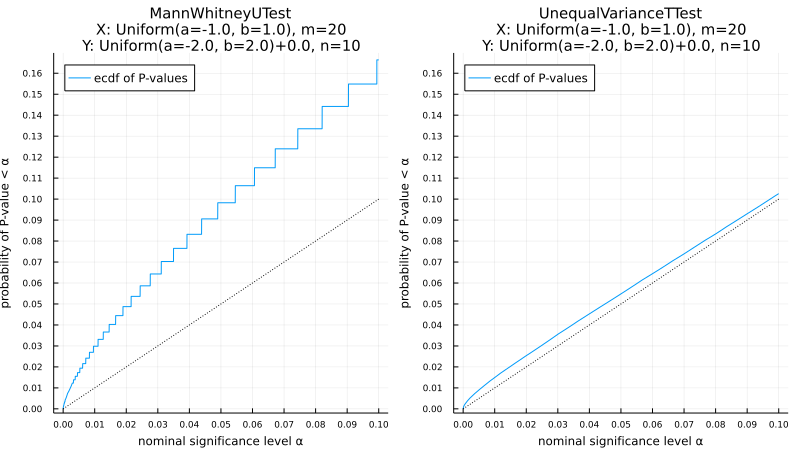

In [34]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 20, n = 10)

(mean(distx), std(distx)) = (0.0, 0.5773502691896257)
(mean(disty), std(disty)) = (0.0, 1.1547005383792515)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  0.858162 seconds (7.00 M allocations: 1.289 GiB, 31.82% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.393726 seconds (9.00 M allocations: 206.007 MiB, 19.00% gc time)


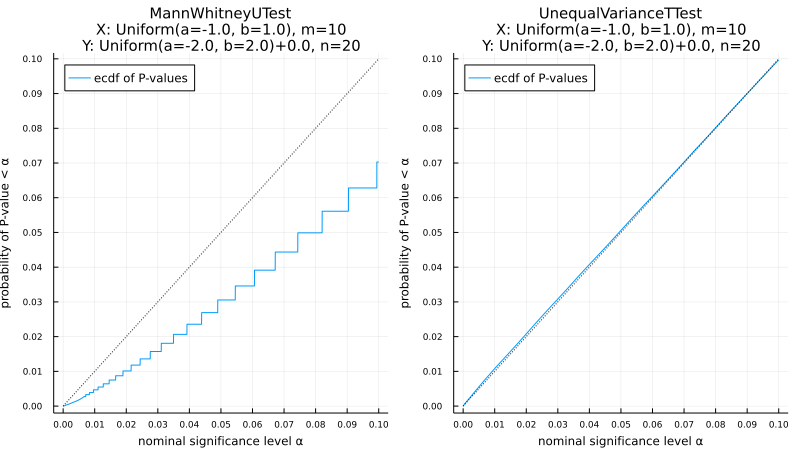

In [35]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 10, n = 20)

(mean(distx), std(distx)) = (0.0, 0.5773502691896257)
(mean(disty), std(disty)) = (0.0, 1.1547005383792515)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.657872 seconds (7.00 M allocations: 2.690 GiB, 39.87% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.308086 seconds (9.00 M allocations: 206.012 MiB)


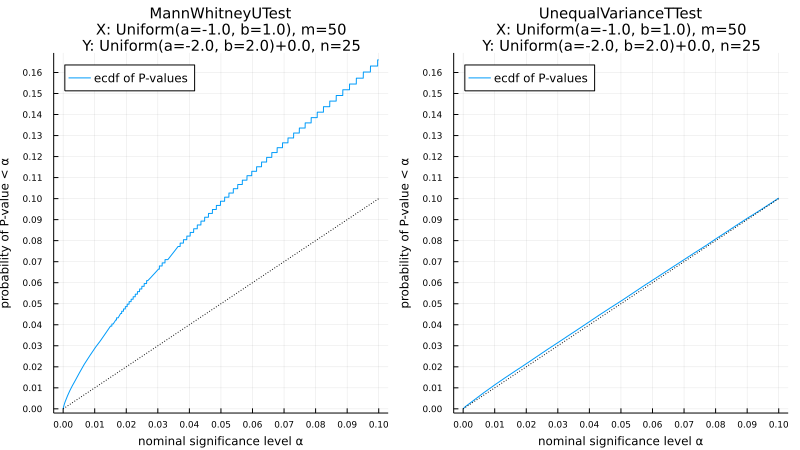

In [36]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 50, n = 25)

(mean(distx), std(distx)) = (0.0, 0.5773502691896257)
(mean(disty), std(disty)) = (0.0, 1.1547005383792515)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5
  1.843905 seconds (7.00 M allocations: 2.690 GiB, 40.51% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  0.357715 seconds (9.00 M allocations: 206.012 MiB)


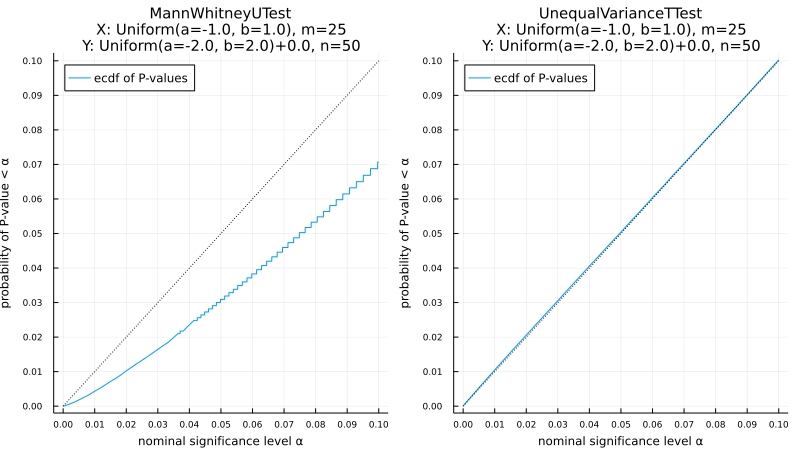

In [37]:
plot_pvals(distx = Uniform(-1, 1), disty = Uniform(-2, 2), m = 25, n = 50)

In [38]:
@doc LogNormal

```
LogNormal(μ,σ)
```

The *log normal distribution* is the distribution of the exponential of a [`Normal`](@ref) variate: if $X \sim \operatorname{Normal}(\mu, \sigma)$ then $\exp(X) \sim \operatorname{LogNormal}(\mu,\sigma)$. The probability density function is

$$
f(x; \mu, \sigma) = \frac{1}{x \sqrt{2 \pi \sigma^2}}
\exp \left( - \frac{(\log(x) - \mu)^2}{2 \sigma^2} \right),
\quad x > 0
$$

```julia
LogNormal()          # Log-normal distribution with zero log-mean and unit scale
LogNormal(μ)         # Log-normal distribution with log-mean mu and unit scale
LogNormal(μ, σ)      # Log-normal distribution with log-mean mu and scale sig

params(d)            # Get the parameters, i.e. (μ, σ)
meanlogx(d)          # Get the mean of log(X), i.e. μ
varlogx(d)           # Get the variance of log(X), i.e. σ^2
stdlogx(d)           # Get the standard deviation of log(X), i.e. σ
```

External links

  * [Log normal distribution on Wikipedia](http://en.wikipedia.org/wiki/Log-normal_distribution)


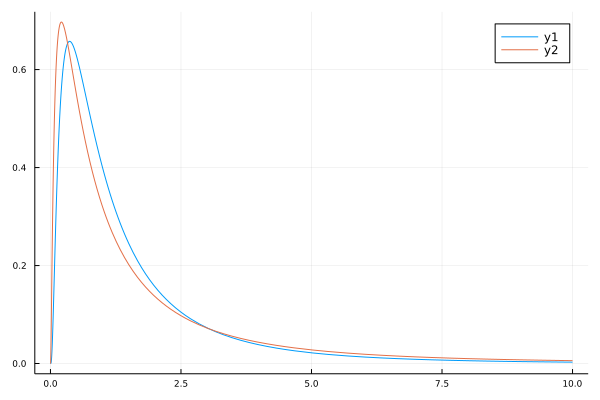

In [39]:
plot(LogNormal(0, 1), 0, 10)
plot!(LogNormal(0, 1.25), 0, 10)

In [40]:
std(LogNormal(0, 1)), std(LogNormal(0, 1.25))

(2.1611974158950877, 4.241363213821604)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (1.6487212707001282, 2.1611974158950877)
a = tieshift(distx, disty) = 7.873419302111289e-12
prob_x_le_y(distx, disty + a) = 0.5
  1.881261 seconds (753.04 k allocations: 3.060 GiB, 31.91% gc time, 2.85% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.473209 seconds (971.58 k allocations: 25.662 MiB, 21.44% compilation time)


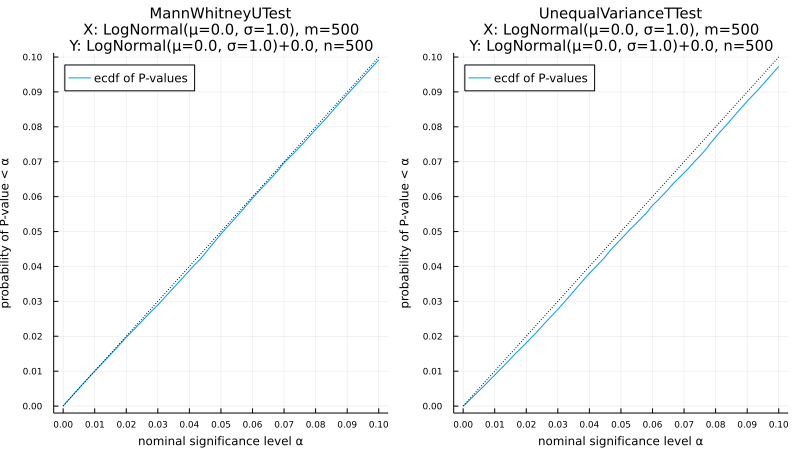

In [41]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1), m = 500, n = 500, L=10^5)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (2.184200810815618, 4.241363213821604)
a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  1.858086 seconds (700.20 k allocations: 3.057 GiB, 33.67% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.293815 seconds (899.69 k allocations: 20.704 MiB)


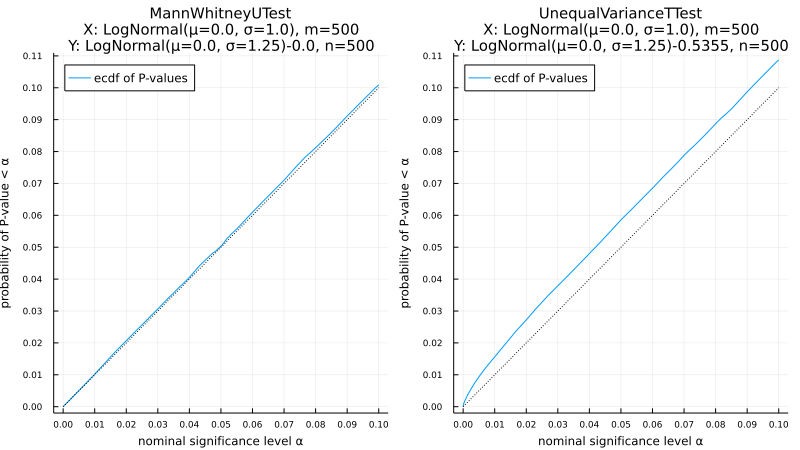

In [42]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 500, n = 500, L=10^5)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (2.184200810815618, 4.241363213821604)
a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  2.740122 seconds (700.20 k allocations: 4.553 GiB, 34.45% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.390644 seconds (899.70 k allocations: 20.749 MiB)


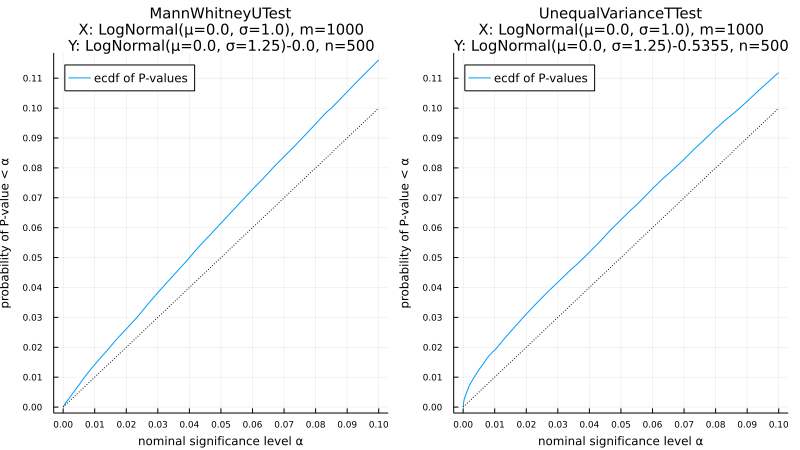

In [43]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 1000, n = 500, L=10^5)

(mean(distx), std(distx)) = (1.6487212707001282, 2.1611974158950877)
(mean(disty), std(disty)) = (2.184200810815618, 4.241363213821604)
a = tieshift(distx, disty) = -8.645021886474966e-11
prob_x_le_y(distx, disty + a) = 0.5
  2.152006 seconds (700.20 k allocations: 4.553 GiB, 24.08% gc time)
Δμ = mean(distx) - mean(disty) = -0.5354795401154897
(mean(distx), mean(disty + Δμ)) = (1.6487212707001282, 1.6487212707001282)
  0.378568 seconds (899.69 k allocations: 20.750 MiB)


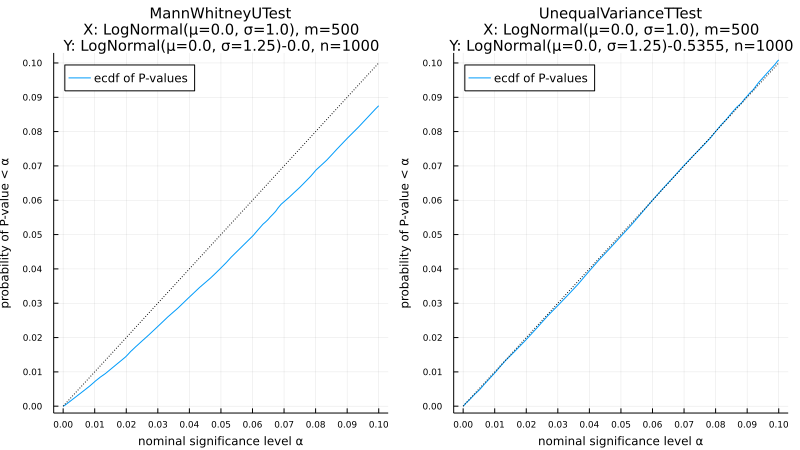

In [44]:
plot_pvals(distx = LogNormal(0, 1), disty = LogNormal(0, 1.25), m = 500, n = 1000, L=10^5)

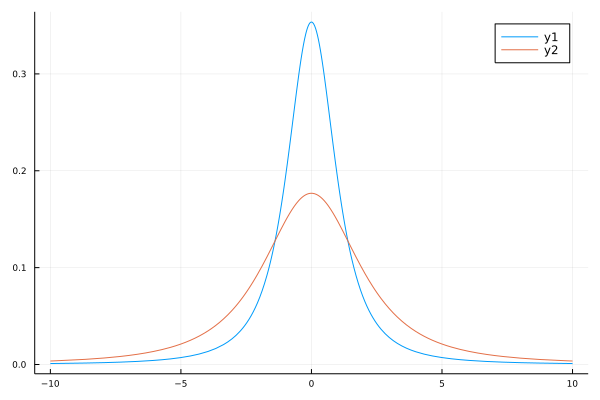

In [45]:
plot(TDist(2), -10, 10)
plot!(2TDist(2), -10, 10)

In [46]:
var(TDist(2)), var(TDist(3)), var(TDist(4)), var(TDist(5))

(Inf, 3.0, 2.0, 1.6666666666666667)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  4.614143 seconds (7.15 M allocations: 6.840 GiB, 38.29% gc time, 1.49% compilation time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.334915 seconds (9.07 M allocations: 210.982 MiB, 8.22% gc time, 8.50% compilation time)


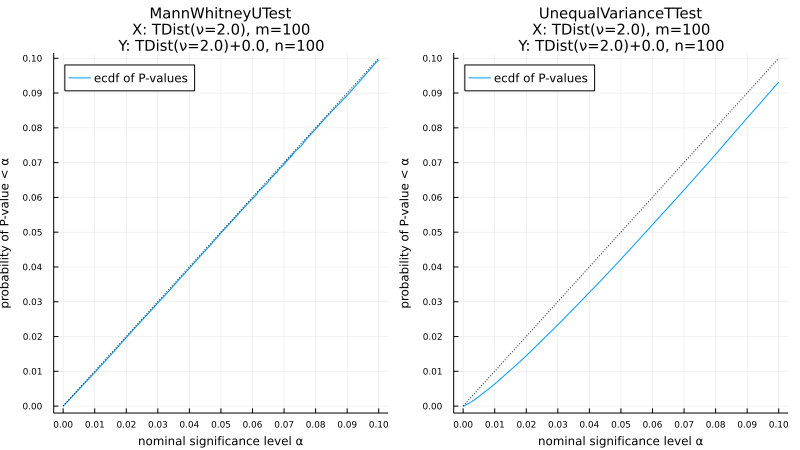

In [47]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 100, n = 100)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  5.426192 seconds (7.00 M allocations: 9.783 GiB, 30.13% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.481133 seconds (9.00 M allocations: 206.034 MiB)


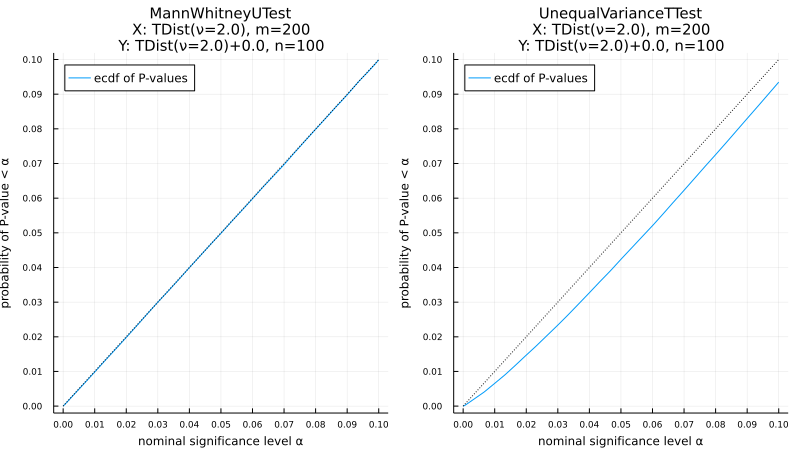

In [48]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 200, n = 100)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000001
  5.330969 seconds (7.00 M allocations: 9.783 GiB, 30.06% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.500224 seconds (9.00 M allocations: 206.034 MiB)


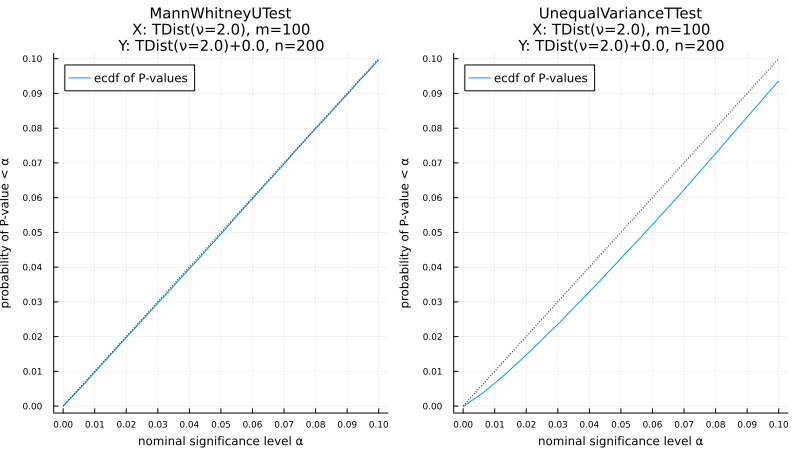

In [49]:
plot_pvals(distx = TDist(2), disty = TDist(2), m = 100, n = 200)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  4.774755 seconds (7.00 M allocations: 6.832 GiB, 38.86% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.084592 seconds (9.00 M allocations: 206.024 MiB)


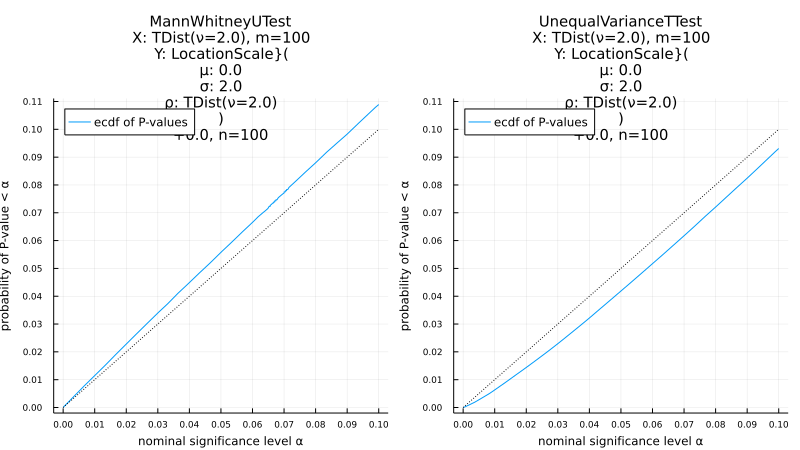

In [50]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 100, n = 100)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  5.303284 seconds (7.00 M allocations: 9.783 GiB, 30.57% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.645494 seconds (9.00 M allocations: 206.034 MiB, 5.56% gc time)


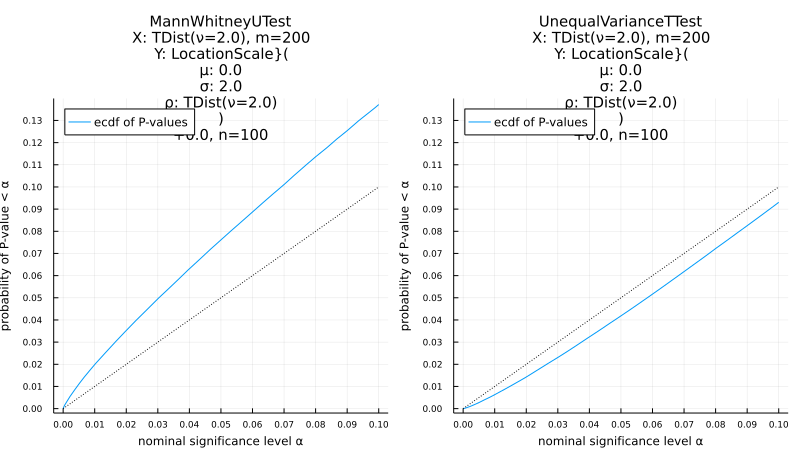

In [51]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 200, n = 100)

(mean(distx), std(distx)) = (0.0, Inf)
(mean(disty), std(disty)) = (0.0, Inf)
a = tieshift(distx, disty) = 0.0
prob_x_le_y(distx, disty + a) = 0.5000000000000002
  5.550785 seconds (7.00 M allocations: 9.783 GiB, 31.12% gc time)
Δμ = mean(distx) - mean(disty) = 0.0
(mean(distx), mean(disty + Δμ)) = (0.0, 0.0)
  1.523139 seconds (9.00 M allocations: 206.034 MiB)


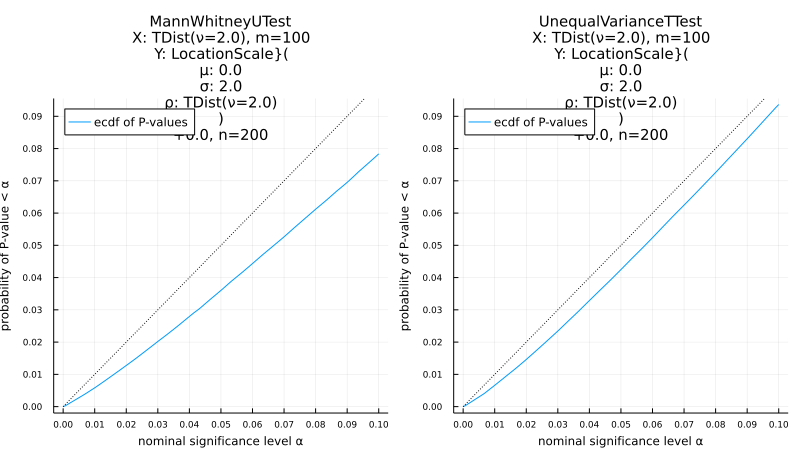

In [52]:
plot_pvals(distx = TDist(2), disty = 2TDist(2), m = 100, n = 200)

## tie shifting vs. median matching

a = tieshift(distx, disty) = -0.8414056600399943
  4.454695 seconds (7.19 M allocations: 6.842 GiB, 40.88% gc time, 1.65% compilation time)
a = median(distx) - median(disty) = -0.6931471805599453
  4.245691 seconds (7.00 M allocations: 6.832 GiB, 43.12% gc time)


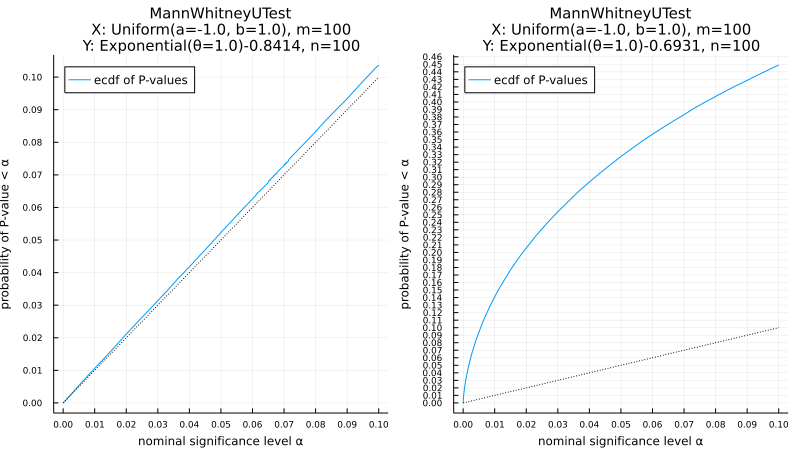

In [53]:
distx, disty = Uniform(-1, 1), Exponential()
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=1.0), 1.0)
tieshift(distx, disty) = -0.8414056600399943
median(distx) - median(disty) = -0.6931471805599453


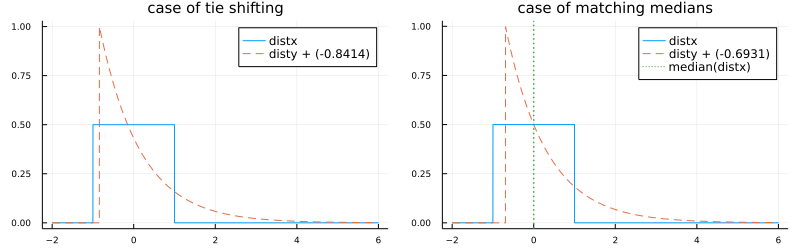

In [54]:
distx, disty = Uniform(-1, 1), Exponential()
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 6; label="distx")
plot!(disty + a, -2, 6; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

a = tieshift(distx, disty) = -2.814168911097315
  4.084880 seconds (7.00 M allocations: 6.832 GiB, 42.17% gc time)
a = median(distx) - median(disty) = -2.772588722239781
  4.633232 seconds (7.00 M allocations: 6.832 GiB, 48.77% gc time)


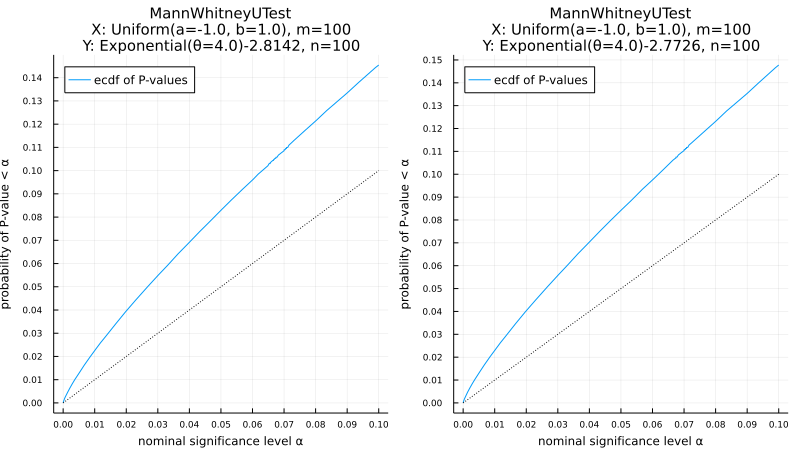

In [55]:
distx, disty = Uniform(-1, 1), Exponential(4)
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=4.0), 4.0)
tieshift(distx, disty) = -2.814168911097315
median(distx) - median(disty) = -2.772588722239781


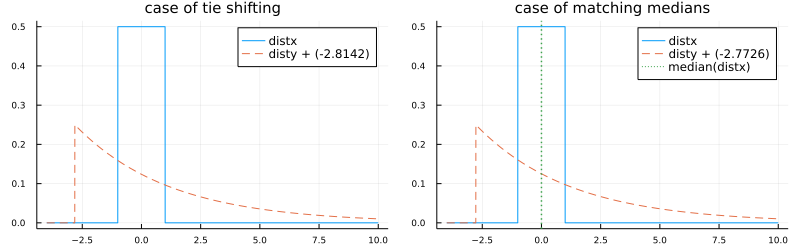

In [56]:
distx, disty = Uniform(-1, 1), Exponential(4)
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -4, 10; label="distx")
plot!(disty + a, -4, 10; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))

a = tieshift(distx, disty) = -0.5370568188698568
  4.512598 seconds (7.00 M allocations: 6.832 GiB, 42.04% gc time)
a = median(distx) - median(disty) = -0.40018871128431455
  3.901256 seconds (7.00 M allocations: 6.832 GiB, 42.39% gc time)


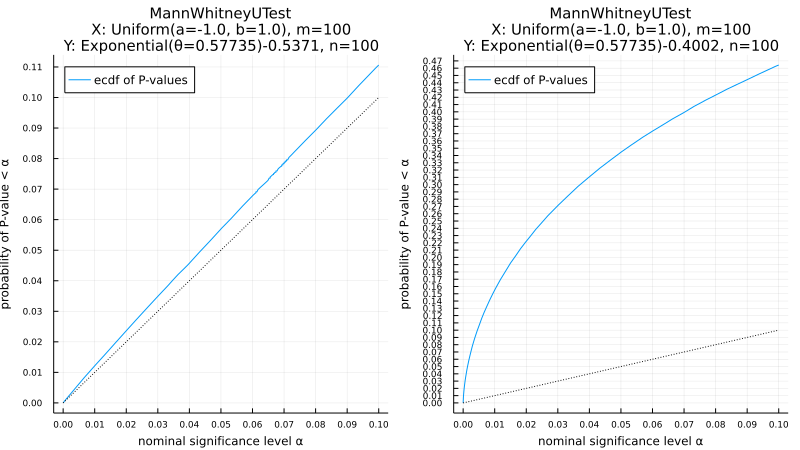

In [57]:
distx, disty = Uniform(-1, 1), Exponential(0.5773502691896257)
m, n, = 100, 100

@show a = tieshift(distx, disty)
ecdf_pval1 = @time sim(; distx = distx, disty = disty + a, m, n)
P1 = plot_ecdf(ecdf_pval1, MannWhitneyUTest, distx, disty, m, n, a)

@show a = median(distx) - median(disty)
ecdf_pval2 = @time sim(; distx = distx, disty = disty + a, m, n)
P2 = plot_ecdf(ecdf_pval2, MannWhitneyUTest, distx, disty, m, n, a)

plot(P1, P2; size=(800, 450), topmargin=4Plots.mm)

(distx, std(distx)) = (Uniform{Float64}(a=-1.0, b=1.0), 0.5773502691896257)
(disty, std(disty)) = (Exponential{Float64}(θ=0.5773502691896257), 0.5773502691896257)
tieshift(distx, disty) = -0.5370568188698568
median(distx) - median(disty) = -0.40018871128431455


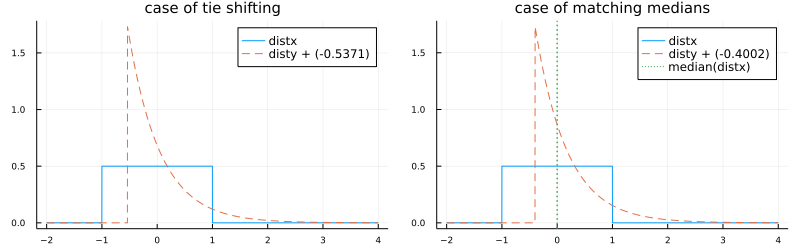

In [58]:
distx, disty = Uniform(-1, 1), Exponential(0.5773502691896257)
@show distx, std(distx)
@show disty, std(disty)

a = @show tieshift(distx, disty)
P1 = plot(distx, -2, 4; label="distx")
plot!(disty + a, -2, 4; label="disty + ($(round(a; digits=4)))", ls=:dash)
title!("case of tie shifting")

a = @show median(distx) - median(disty)
P2 = plot(distx, -2, 4; label="distx")
plot!(disty + a, -2, 4; label="disty + ($(round(a; digits=4)))", ls=:dash)
vline!([median(distx)]; label="median(distx)", ls=:dot, lw=1.5)
title!("case of matching medians")

plot(P1, P2; size=(800, 250))